In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, plot_confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Pre-Modeling

#### Assemble the data

##### Data available after preprocessing: [Resources](https://github.com/Marwan-Takrouri/Human-or-Robot-Facebook-Kaggle/tree/main/Resources_for_modeling)
- bidders.csv: groupby bidder_id, then count unique value of auctions, merchandise, device, country, ip, url, timediff for each bidder, and the highest order rank and total number of bids the bidder participated. Last are the mean, sd of timediff.  
- bidder_encoding.csv: groupby bidder_id, then encode device, country and merchandis.
- bidder_auc.csv: groupby bidder_id and auction, then count unique value of  merchandise, device, country, ip, url, timediff for each bidder, and the highest order rank and total number of bids the bidder participated in corresponding auction. Last are the mean, sd of timediff.

In [49]:
bidders = pd.read_csv("./Resources/bidders.csv", index_col =False)
bidder_encoding = pd.read_csv("./Resources/bidder_encoding.csv", index_col =False)
bidder_auc = pd.read_csv("./Resources/bidder_auc.csv")
train = pd.read_csv("./Resources/train.csv")

bidders = bidders.merge(bidder_encoding, right_index=True, left_index=True)
# bidders = bidders.merge(bidder_auc, right_index=True, left_index=True)

print(bidders.shape)
bidders.head()

(6614, 52)


,bidder_id,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,bidder_rank_min,bid_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,001068c415025a009fee375a12cff4fcnht8y,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1899.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,002d229ffb247009810828f648afc2ef593rb,1.0,1.0,2.0,1.0,1.0,1.0,1.0,51.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0030a2dd87ad2733e0873062e4f83954mkj86,1.0,1.0,1.0,1.0,1.0,1.0,0.0,23448.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3.0,1.0,3.0,1.0,3.0,2.0,2.0,121.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00486a11dff552c4bd7696265724ff81yeo9v,13.0,1.0,8.0,1.0,10.0,7.0,19.0,62.0,20.0,...,0.0,0.0,0.0,0.0,0.0,2.0,7.0,5.0,0.0,2.0


Since in [Explore the data](https://github.com/Marwan-Takrouri/Human-or-Robot-Facebook-Kaggle/blob/main/Explore_the_data.ipynb) we found the bidders who never bid are all human, just ignore them with inner join 

In [50]:
# merged_bidders = train.merge(bidders, how= "left", on="bidder_id")
 
merged_bidders = train.merge(bidders, how= "inner", on="bidder_id")
# merged_bidders = train.merge(bidder_auc, how= "inner", on="bidder_id")

print(merged_bidders.shape)
merged_bidders.head()

(1984, 55)


,bidder_id,payment_account,address,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18.0,1.0,14.0,6.0,20.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1.0,1.0,2.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,1.0,2.0,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23.0,1.0,53.0,2.0,123.0,91.0,...,1.0,1.0,7.0,0.0,11.0,1.0,19.0,5.0,0.0,0.0


Since each bidder in train dataset has corresponding unique payment account and address, and bidder_id is also a unique id that won't be useful for machine lerning. <br>
These three columns could be dropped.

In [51]:
merged_bidders = merged_bidders.drop(columns=["bidder_id","payment_account", "address"])
# merged_bidders = merged_bidders.drop(columns=["auction"])

print(merged_bidders.shape)
merged_bidders.head()

(1984, 52)


,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,bidder_rank_min,bid_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,0.0,18.0,1.0,14.0,6.0,20.0,1.0,23.0,5.0,24.0,...,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0
1,0.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,73166.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,1.0,2.0,1.0,4.0,2.0,3.0,396.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1395.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,23.0,1.0,53.0,2.0,123.0,91.0,143.0,4.0,155.0,...,1.0,1.0,7.0,0.0,11.0,1.0,19.0,5.0,0.0,0.0


In [52]:
merged_bidders.country_id

0           0.0
1           3.0
2           4.0
3           0.0
4           0.0
5           0.0
6           8.0
7           0.0
8           0.0
9           1.0
10          0.0
11          8.0
12          0.0
13          0.0
14          0.0
15          0.0
16          6.0
17        104.0
18          0.0
19          0.0
20          3.0
21        150.0
22         35.0
23          0.0
24          0.0
25          0.0
26        203.0
27          0.0
28          0.0
29          1.0
30          2.0
31          0.0
32         35.0
33          0.0
34         85.0
35       2825.0
36          0.0
37        380.0
38          5.0
39          1.0
40         14.0
41          0.0
42          0.0
43          0.0
44          0.0
45          0.0
46          0.0
47          0.0
48          0.0
49         83.0
50          0.0
51         10.0
52          0.0
53          0.0
54          5.0
55          0.0
56          2.0
57          0.0
58          0.0
59          1.0
60         29.0
61          2.0
62      

In [44]:
merged_bidders.sort_values(["time_mean"], ascending=True)

,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,bidder_rank_min,bid_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
1842,0.0,748.0,1.0,2020.0,76.0,53405.0,36518.0,79.0,1.0,192565.0,...,3293.0,884.0,3197.0,567.0,561.0,8087.0,26560.0,5910.0,81.0,4798.0
877,0.0,59.0,1.0,251.0,32.0,610.0,1559.0,29.0,8.0,3041.0,...,45.0,19.0,92.0,7.0,25.0,17.0,33.0,186.0,14.0,172.0
1181,1.0,6.0,1.0,1.0,1.0,177.0,5.0,14.0,394.0,177.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
509,1.0,6.0,1.0,1.0,1.0,165.0,5.0,16.0,308.0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1795,0.0,1256.0,1.0,2618.0,98.0,101275.0,81376.0,81.0,1.0,515033.0,...,7701.0,2462.0,9074.0,1732.0,2831.0,23939.0,67769.0,20869.0,133.0,13202.0
166,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3292.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1692,0.0,963.0,1.0,1610.0,125.0,27560.0,13416.0,96.0,1.0,84319.0,...,1525.0,361.0,1691.0,679.0,791.0,2844.0,18438.0,1925.0,34.0,1221.0
1841,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3316.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353,0.0,1301.0,1.0,1040.0,48.0,24901.0,14907.0,124.0,1.0,51421.0,...,1519.0,1732.0,482.0,0.0,1493.0,1079.0,7404.0,105.0,0.0,19.0
219,0.0,406.0,1.0,274.0,57.0,15337.0,254.0,154.0,1.0,48018.0,...,798.0,997.0,229.0,0.0,219.0,73.0,2.0,110.0,0.0,3.0


Total bids made by robots: 103
Total bids made by human:  1881


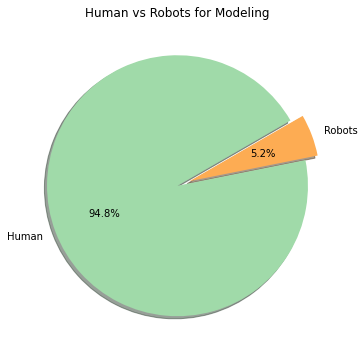

In [7]:
# Human and Robot distribution
print(f"Total bids made by robots: {len(merged_bidders[merged_bidders['outcome'] == 1])}")
print(f"Total bids made by human:  {len(merged_bidders[merged_bidders['outcome'] == 0])}")

x = merged_bidders.outcome.value_counts()

plt.subplots(figsize=(10, 6))
plt.pie(x, labels=["Human", "Robots"], colors=["#A0DAA9", "#FDAC53"],explode=[0, 0.1], autopct='%1.1f%%', shadow=True,startangle=30)
plt.title("Human vs Robots for Modeling")
mpl.rcParams['font.size'] = 14
plt.savefig("Images/human_bot_modeling.png")
plt.show()

Still a severely imbalanced dataset. Therefore we will choose models fit imbalanced data.

In [45]:
# merged_bidders.to_csv("./Resources/merged_bidders.csv", index=False)

In [53]:
model_data = merged_bidders.copy()

In [111]:
# Feature selection, drop unrelated features if necessary
# columns_to_drop = []
# model_data.drop(columns_to_drop, axis=1, inplace=True)
# print(model_data.shape)
# model_data.head()

(1984, 46)


,outcome,auction_count,device_count,country_count,ip_count,url_count,bidder_rank_min,bid_count,time_mean,time_median,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,0.0,18.0,14.0,6.0,20.0,1.0,5.0,24.0,5.711121e+11,3.458421e+11,...,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0
1,0.0,1.0,2.0,1.0,3.0,2.0,73166.0,3.0,3.233579e+12,3.233579e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,2.0,1.0,4.0,2.0,396.0,4.0,2.379000e+12,2.532053e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1395.0,1.0,3.488293e+12,2.212457e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,23.0,53.0,2.0,123.0,91.0,4.0,155.0,7.777888e+10,1.368421e+10,...,1.0,1.0,7.0,0.0,11.0,1.0,19.0,5.0,0.0,0.0


#### Spilt and scale the data

In [54]:
# Split our preprocessed data into features and target arrays
y = model_data["outcome"].values
X = model_data.drop(columns= "outcome", axis= 1).values

# Split the preprocessed data into a training and testing dataset
# Default
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Customize the split size
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.8)

In [85]:
# Create a Scaler instances: Try two scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Balanced RandomForest Classifier

In [97]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.8872340425531915
Confusion Matrix


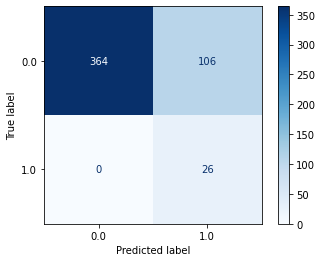

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.77      1.00      0.87      0.88      0.76       470
        1.0       0.20      1.00      0.77      0.33      0.88      0.79        26

avg / total       0.96      0.79      0.99      0.84      0.88      0.76       496



In [98]:
brf_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {brf_acc}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

In [99]:
# List the features sorted in descending order by feature importance
x = merged_bidders.drop(columns= "outcome", axis= 1)
import_score = model.fit(X_train, y_train).feature_importances_
import_rank = sorted(zip(import_score, x.columns), reverse=True)
importances = pd.DataFrame(import_rank, columns=["Feature Score", "Features"])
importances = importances[["Features", "Feature Score"]]
importances.index = np.arange(1, len(importances)+1)
importances.head()

,Features,Feature Score
1,time_mean,0.146199
2,time_median,0.088348
3,device_Others,0.087834
4,bid_count,0.071759
5,country_Others,0.051738


In [59]:
# Save data
# importances.to_csv("./Resources/importances.csv")

In [100]:
# Get the top 10 importances
top_10 = importances.head(10)
top_10

,Features,Feature Score
1,time_mean,0.146199
2,time_median,0.088348
3,device_Others,0.087834
4,bid_count,0.071759
5,country_Others,0.051738
6,bidder_rank_min,0.051117
7,time_std,0.036343
8,timediff_count,0.033584
9,device_phone65,0.031797
10,country_id,0.027021


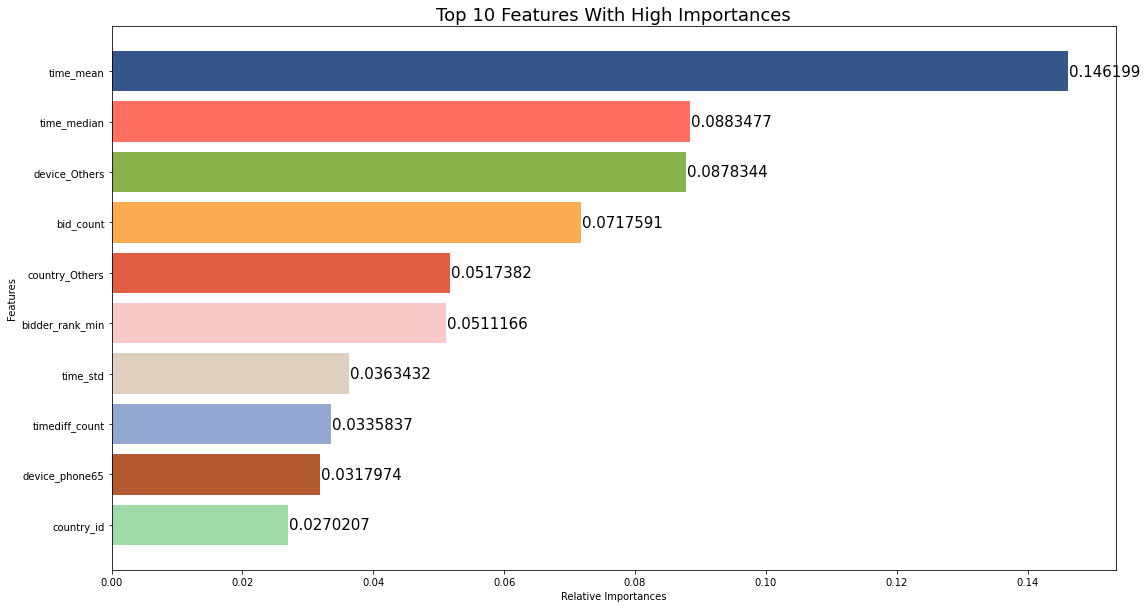

In [101]:
# Plot the importances
fig, ax = plt.subplots(figsize=(18,10))

x_value = top_10["Features"]
y_value = top_10["Feature Score"].values

color = ["#34568B", "#FF6F61", "#88B04B", "#FDAC53", "#E15D44", "#F7CAC9", "#DFCFBE", "#92A8D1", "#B55A30", "#A0DAA9"]
top10_plot = plt.barh(x_value, y_value, color = color)
plt.ylabel("Features")
plt.title("Top 10 Features With High Importances", fontsize=18)
plt.xlabel("Relative Importances")
ax.bar_label(top10_plot, padding=1, fontsize=15)
plt.gca().invert_yaxis()
plt.savefig("Images/Importances.png")
plt.show()

As can be seen in the graph above, a wide variety of  features emerge as significant in the Balanced RF model.

#### Easy Ensemble Classifier

In [102]:
from imblearn.ensemble import EasyEnsembleClassifier
model = EasyEnsembleClassifier(n_estimators=200 ,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.782569558101473
Confusion Matrix


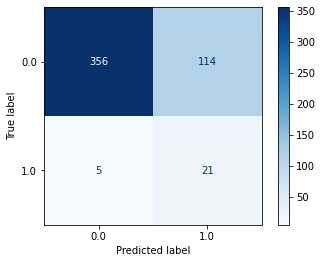

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.76      0.81      0.86      0.78      0.61       470
        1.0       0.16      0.81      0.76      0.26      0.78      0.61        26

avg / total       0.94      0.76      0.81      0.83      0.78      0.61       496



In [103]:
eec_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {eec_acc}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

#### Gradient Boosting Classifier

In [104]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=200, random_state= 42, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.6239770867430442
Confusion Matrix


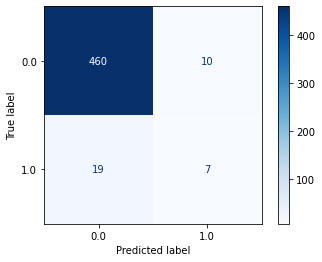

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.98      0.27      0.97      0.51      0.28       470
        1.0       0.41      0.27      0.98      0.33      0.51      0.24        26

avg / total       0.93      0.94      0.31      0.94      0.51      0.28       496



In [105]:
gbc_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {gbc_acc}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

#### Ada Boost Classifier

In [106]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.682733224222586
Confusion Matrix


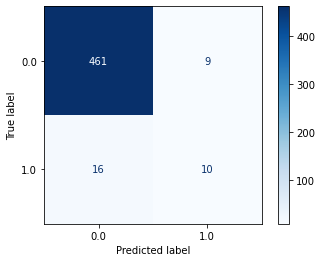

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.98      0.38      0.97      0.61      0.40       470
        1.0       0.53      0.38      0.98      0.44      0.61      0.35        26

avg / total       0.94      0.95      0.42      0.95      0.61      0.40       496



In [107]:
abc_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {abc_acc}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

### Model Comparision

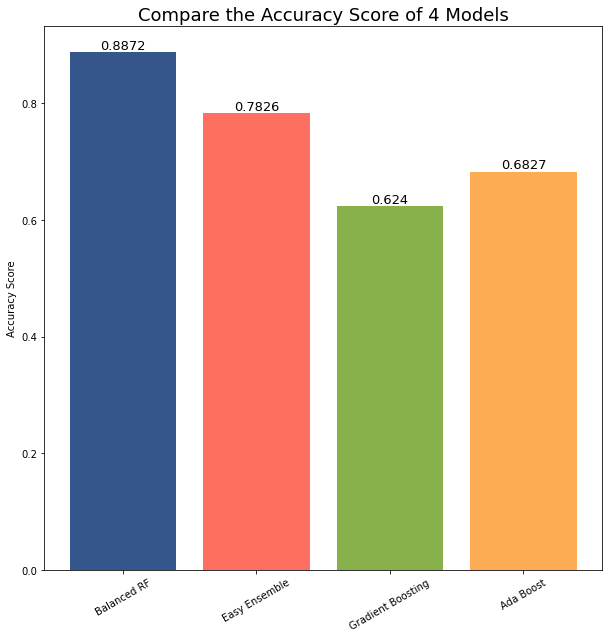

In [108]:
model_acc = [brf_acc, eec_acc, gbc_acc, abc_acc]
labels = ["Balanced RF", "Easy Ensemble", "Gradient Boosting", "Ada Boost"]
x_model = np.arange(len(labels)) 
y_model = [round(num, 4) for num in model_acc]

fig, ax = plt.subplots(figsize=(10,10))
comparision = plt.bar(x_model , y_model, color = color, align="center")
plt.ylabel("Accuracy Score")
plt.title("Compare the Accuracy Score of 4 Models", fontsize=18)
plt.xticks(x_model, labels)
ax.bar_label(comparision, fontsize=13)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="center")
plt.savefig("Images/model_comparision.png", dpi=100)

plt.show()

Easy Ensemble Classifier has the highest accuracy score, therefore we will use this model to train and predict the test data.

In [69]:
# Save the data
# model_comparisionn = pd.DataFrame({"Model": labels, "Accuracy": model_acc})
# model_comparisionn.to_csv("./Resources/model_comparision.csv")

,Model,Accuracy
0,Balanced RF,0.887234
1,Easy Ensemble,0.782570
2,Gradient Boosting,0.623977
3,Ada Boost,0.682733


### Submission

In [310]:
test = pd.read_csv("./Resources/test.csv")

In [311]:
merged_test = test.merge(bidders, how= "left", on="bidder_id")
merged_test.head()

,bidder_id,payment_account,address,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c,3.0,1.0,2.0,3.0,4.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn,2.0,1.0,3.0,2.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0,14.0,1.0,4.0,3.0,4.0,2.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat,90.0,1.0,81.0,14.0,129.0,80.0,145.0,...,6.0,1.0,0.0,0.0,4.0,1.0,20.0,0.0,1.0,0.0
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa,20.0,1.0,17.0,2.0,17.0,1.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [312]:
test_id = merged_test["bidder_id"]

In [313]:
merged_test.fillna(merged_test.mean(), inplace=True)

In [315]:
y_train = model_data["outcome"].values
X_train = model_data.drop(columns= "outcome", axis= 1).values
X_test = merged_test.drop(columns=["bidder_id", "payment_account", "address"])

In [316]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)

In [317]:
model = BalancedRandomForestClassifier(n_estimators=230, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test)

In [319]:
submission = pd.read_csv("./Resources/sampleSubmission.csv")
result = pd.DataFrame({"bidder_id": test_id, "predicts": y_pred})
final_sub = submission.merge(result, on="bidder_id", how= "left")
final_sub = final_sub.drop(columns= "prediction", axis = 1)

In [320]:
final_sub["predicts"].value_counts()

0.0    3522
1.0    1178
Name: predicts, dtype: int64

In [321]:
final_sub.isnull().sum()

bidder_id    0
predicts     0
dtype: int64

In [322]:
final_sub.to_csv("Final_results.csv", index=False, header=["bidder_id", "prediction"])

This submission should score around 0.86417 on the private leaderboard for a rank of top 50%.